In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/MyDrive/ComPhoto

/content/drive/MyDrive/ComPhoto


# Read all frame

In [4]:
import sys
from match_pairs import *
from pathlib import Path
import argparse
import random
import numpy as np
import matplotlib.cm as cm
import torch

import sys

from models.matching import Matching
from models.utils import frame2tensor

import matplotlib.pyplot as plt


In [5]:
# Load the SuperPoint and SuperGlue models.
# device = 'cuda' if torch.cuda.is_available() and not opt.force_cpu else 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Running inference on device \"{}\"'.format(device))
config = {
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': 1024
    },
    'superglue': {
        'weights': 'outdoor', # {'indoor', 'outdoor'}
        'sinkhorn_iterations': 20,
        'match_threshold': 0.2,
    }
}
matching = Matching(config).eval().to(device)

Running inference on device "cuda"
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [6]:
import os
import sys

import cv2
import numpy as np


def save_image(img, name):
    result_image_name = os.path.join('results/', f'result_{name}.jpg')
    cv2.imwrite(result_image_name, img)


def show_image(img, title, width=1024, inter=cv2.INTER_AREA):
    (h, w) = img.shape[:2]
    r = width / float(w)
    dim = (width, int(h * r))
    resized = cv2.resize(img, dim, interpolation=inter)
    cv2.imshow(title, resized)

def getFrame(path, save=False):
    print(f"File {path} exists: ", os.path.exists(path))
    vidcap = cv2.VideoCapture(path)
    success, image = vidcap.read()
    count = 0
    i = 0
    frames = []
    every = 3
    while success:
        if (count % every == 0):
            if save:
                cv2.imwrite("./frames/frame%d.jpg" % (i), image)     # save frame as JPEG file, could delete later  
            frames.append(image)
            i += 1
        success,image = vidcap.read()
        count += 1
        if count == 60:
            break
    return frames

In [7]:
frames = getFrame("video/cut_video.mp4")

File video/cut_video.mp4 exists:  True


In [8]:
len(frames)

20

# Sitch

In [9]:
def get_match_pair(image0, image1):
    do_match = True

    # Load the image pair.
    image0 = cv2.cvtColor(image0, cv2.COLOR_BGR2GRAY)
    inp0 = frame2tensor(image0, device)

    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    inp1 = frame2tensor(image1, device)

    if image0 is None or image1 is None:
        print('Problem reading image pair: {} {}'.format(
            input_dir/name0, input_dir/name1))
        exit(1)

    if do_match:
        # Perform the matching.
        pred = matching({'image0': inp0, 'image1': inp1})
        pred = {k: v[0].cpu().numpy() for k, v in pred.items()}
        kpts0, kpts1 = pred['keypoints0'], pred['keypoints1']
        matches, conf = pred['matches0'], pred['matching_scores0']

        # Write the matches to disk.
        out_matches = {'keypoints0': kpts0, 'keypoints1': kpts1,
                       'matches': matches, 'match_confidence': conf}
        return out_matches

    # Keep the matching keypoints.
    valid = matches > -1
    mkpts0 = kpts0[valid]
    mkpts1 = kpts1[matches[valid]]
    mconf = conf[valid]


In [19]:
import os
import sys
# from turtle import width

import cv2
import numpy as np
# import laplcian_blending
# from ransac import ransac
# from Homography import Homography

x1 = -1
x2 = -1
# Use the keypoints to stitch the images
def get_stitched_image(img1, img2, M):
    global x1, x2
    # Get width and height of input images
    w1, h1 = img1.shape[:2]
    w2, h2 = img2.shape[:2]

    # Get the canvas dimesions
    img1_dims = np.float32([[0, 0], [0, w1], [h1, w1], [h1, 0]]).reshape(-1, 1, 2)
    img2_dims_temp = np.float32([[0, 0], [0, w2], [h2, w2], [h2, 0]]).reshape(-1, 1, 2)

    # Get relative perspective of second image
    img2_dims = cv2.perspectiveTransform(img2_dims_temp,
                                         M)  # Image 2 is converted to the same coordinate system as image 1 using Homography mat

    # Resulting dimensions

    result_dims = np.concatenate((img1_dims, img2_dims), axis=0)

    # Getting images together
    # Calculate dimensions of match points
    [x_min, y_min] = np.int32(result_dims.min(axis=0).ravel() - 0.5)  # Scale out by one pixel
    [x_max, y_max] = np.int32(result_dims.max(axis=0).ravel() + 0.5)

    # Create output array after affine transformation
    transform_dist = [-x_min, -y_min]
    transform_array = np.array([[1, 0, transform_dist[0]],
                                [0, 1, transform_dist[1]],
                                [0, 0, 1]])

    # Warp images to get the resulting image
    result_img = cv2.warpPerspective(img2, transform_array.dot(M),
                                     (x_max - x_min, y_max - y_min))
    result_img[transform_dist[1]:w1 + transform_dist[1],
    transform_dist[0]:h1 + transform_dist[
        0]] = img1  # image2 is transformed to result_image through perspective transformation,
    x1 = transform_dist[1]
    x2 = w1 + transform_dist[1]
    return result_img


# Find SIFT and return Homography Matrix
def get_sift_homography(img1, img2):
    # Initialize SIFT
    sift = cv2.SIFT_create()

    # Extract keypoints and descriptors
    kp1, d1 = sift.detectAndCompute(img1, None)
    kp2, d2 = sift.detectAndCompute(img2, None)

    # Bruteforce matcher on the descriptors
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)  # k1 and k2 match each other to find the smallest distance pair
    knnMatches = bf.knnMatch(d1, d2, k=2)  # one keypoint match two other keypoints

    # Make sure that the matches are good
    good_ratio = 0.8  # Source: stackoverflow
    good_matches = []
    for m1, m2 in knnMatches:
        # Add to array only if it's a good match
        if m1.distance < good_ratio * m2.distance:
            good_matches.append(m1)

    # Mimnum number of matches
    min_matches = 8
    if len(good_matches) > min_matches:

        # Array to store matching points
        img1_pts = []
        img2_pts = []

        # Add matching points to array
        for match in good_matches:
            img1_pts.append(kp1[match.queryIdx].pt + (1,))
            img2_pts.append(kp2[match.trainIdx].pt + (1,))
        img1_pts = np.float32(img1_pts).reshape(-1, 1, 3)
        img2_pts = np.float32(img2_pts).reshape(-1, 1, 3)

        # Compute homography matrix
        M, mask = cv2.findHomography(img1_pts, img2_pts, cv2.RANSAC, 5.0)  # x2 = M*x1  many times choose
        # inlier = ransac(img1_pts, img2_pts, 5.0, 1000)  # x2 = M*x1  many times choose
        # M = Homography(inlier)
        # four points to calculate and use RANSAC to choose the best one
        return M, img1, img2
    else:
        print('Error: Not enough matches')
        exit()

def get_superglue_homography(img1, img2):
    results = get_match_pair(img1, img2)

    kpts0, kpts1 = results['keypoints0'], results['keypoints1']
    matches, conf = results['matches'], results['match_confidence']
    valid = matches > -1

    mkpts0 = kpts0[valid]
    mkpts1 = kpts1[matches[valid]]
    confidences = conf[valid]

    # Make sure that the matches are good
    good_ratio = 0.5  # Source: Superglue default
    good_matches = []
    for i, matches in enumerate(zip(mkpts0, mkpts1)):
        kp1, kp2 = matches
        # Add to array only if it's a good match
        if confidences[i] > good_ratio:
            good_matches.append((kp1, kp2))
    # print('len(good_matches)', len(good_matches))
    # Mimnum number of matches
    min_matches = 8
    if len(good_matches) > min_matches:

        # Array to store matching points
        img1_pts = []
        img2_pts = []

        # Add matching points to array
        for match in good_matches:
            img1_pts.append(tuple(match[0]) + (1,))
            img2_pts.append(tuple(match[1]) + (1,))
        # print('len(img1_pts)', len(img1_pts), img1_pts[0])
        img1_pts = np.float32(img1_pts).reshape(-1, 1, 3)
        img2_pts = np.float32(img2_pts).reshape(-1, 1, 3)

        # Compute homography matrix
        M, mask = cv2.findHomography(img1_pts, img2_pts, cv2.RANSAC, 5.0)  # x2 = M*x1  many times choose
        # inlier = ransac(img1_pts, img2_pts, 5.0, 1000)  # x2 = M*x1  many times choose
        # M = Homography(inlier)
        # four points to calculate and use RANSAC to choose the best one
        return M, img1, img2
    else:
        print('Error: Not enough matches')
        exit()


# Equalize Histogram of Color Images improve image contrast
def equalize_histogram_color(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)  # Avoid losing information in integer calculations
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img

match_count = 0


def draw_matched_keypoint(img1, img2, wait=False):
    global match_count
    img1 = img1.copy()
    img2 = img2.copy()

    sift = cv2.SIFT_create(100)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    # draw the keypoints
    img1 = cv2.drawKeypoints(image=img1, keypoints=kp1, outImage=img1, color=(255, 0, 255),
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2 = cv2.drawKeypoints(image=img2, keypoints=kp2, outImage=img2, color=(255, 0, 255),
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    cv2.waitKey(20)

    bf = cv2.BFMatcher()
    knnMatches = bf.knnMatch(des1, des2, k=2)
    print(type(knnMatches), len(knnMatches), knnMatches[0])
    # # Get the first descriptor in img1 with the most matching descriptor in img2 with the smallest distance
    dMatch0 = knnMatches[0][0]
    # # Get the first descriptor in img1 that matches the next descriptor in img2, followed by the distance
    dMatch1 = knnMatches[0][1]
    print('knnMatches', dMatch0.distance, dMatch0.queryIdx, dMatch0.trainIdx)
    print('knnMatches', dMatch1.distance, dMatch1.queryIdx, dMatch1.trainIdx)
    # Make sure that the matches are good
    goodMatches = []
    minRatio = 0.8
    for m, n in knnMatches:
        if m.distance / n.distance < minRatio:
            goodMatches.append([m])

    print(len(goodMatches))
    sorted(goodMatches, key=lambda x: x[0].distance)
    # # draw verified matches
    outImg = None
    outImg = cv2.drawMatchesKnn(img1, kp1, img2, kp2, goodMatches, outImg, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
    match_count += 1
    show_image(outImg, f'Match {match_count}')
    save_image(outImg, f'Match {match_count}')
    if wait:
        cv2.waitKey(0)
        cv2.destroyAllWindows()


def stitch_images(img1, img2, mode='sift'):
    # Equalize histogram
    img1 = equalize_histogram_color(img1)
    img2 = equalize_histogram_color(img2)
    
    if mode.lower() == 'sift':
        M, img1, img2 = get_sift_homography(img1, img2)
    else:
        # Use SIFT to find keypoints and return homography matrix
        M, img1_key, img2_key = get_superglue_homography(img1, img2)

    # M, img1_key, img2_key = get_superglue_homography(img1, img2)

    # Stitch the images together using homography matrix
    return get_stitched_image(img2, img1, M)
    # return get_stitched_image(img2, img1, M), [img1_key, img2_key]


def save_image(img, name):
    result_image_name = os.path.join('results/', f'result_{name}.jpg')
    cv2.imwrite(result_image_name, img)


def show_image(img, title, width=1024, inter=cv2.INTER_AREA):
    (h, w) = img.shape[:2]
    r = width / float(w)
    dim = (width, int(h * r))
    resized = cv2.resize(img, dim, interpolation=inter)
    cv2.imshow(title, resized)


In [ ]:
img1 = frames[0]
img2 = frames[-1]
for mode in ['sift', 'glue']:
    res = stitch_images(img1, img2, mode)
    cv2.imwrite(f'result_{mode}.jpg', img1)
    middle = res[x1:x2,:][:, -w:]
    cv2.imwrite(f'result_{mode}_middle.jpg', middle)


In [14]:
from google.colab.patches import cv2_imshow

cv2_imshow(res)

ModuleNotFoundError: No module named 'google.colab'

In [1]:
h, w, _ = frames[10].shape
cv2_imshow(abs(res[x1:x2,:][:, -w:].mean(axis=-1) - cv2.imread('result_sift_middle.jpg').mean(axis=-1)))


NameError: name 'frames' is not defined

In [35]:
# height, width = res.shape
frames[10].shape

(1080, 1920, 3)

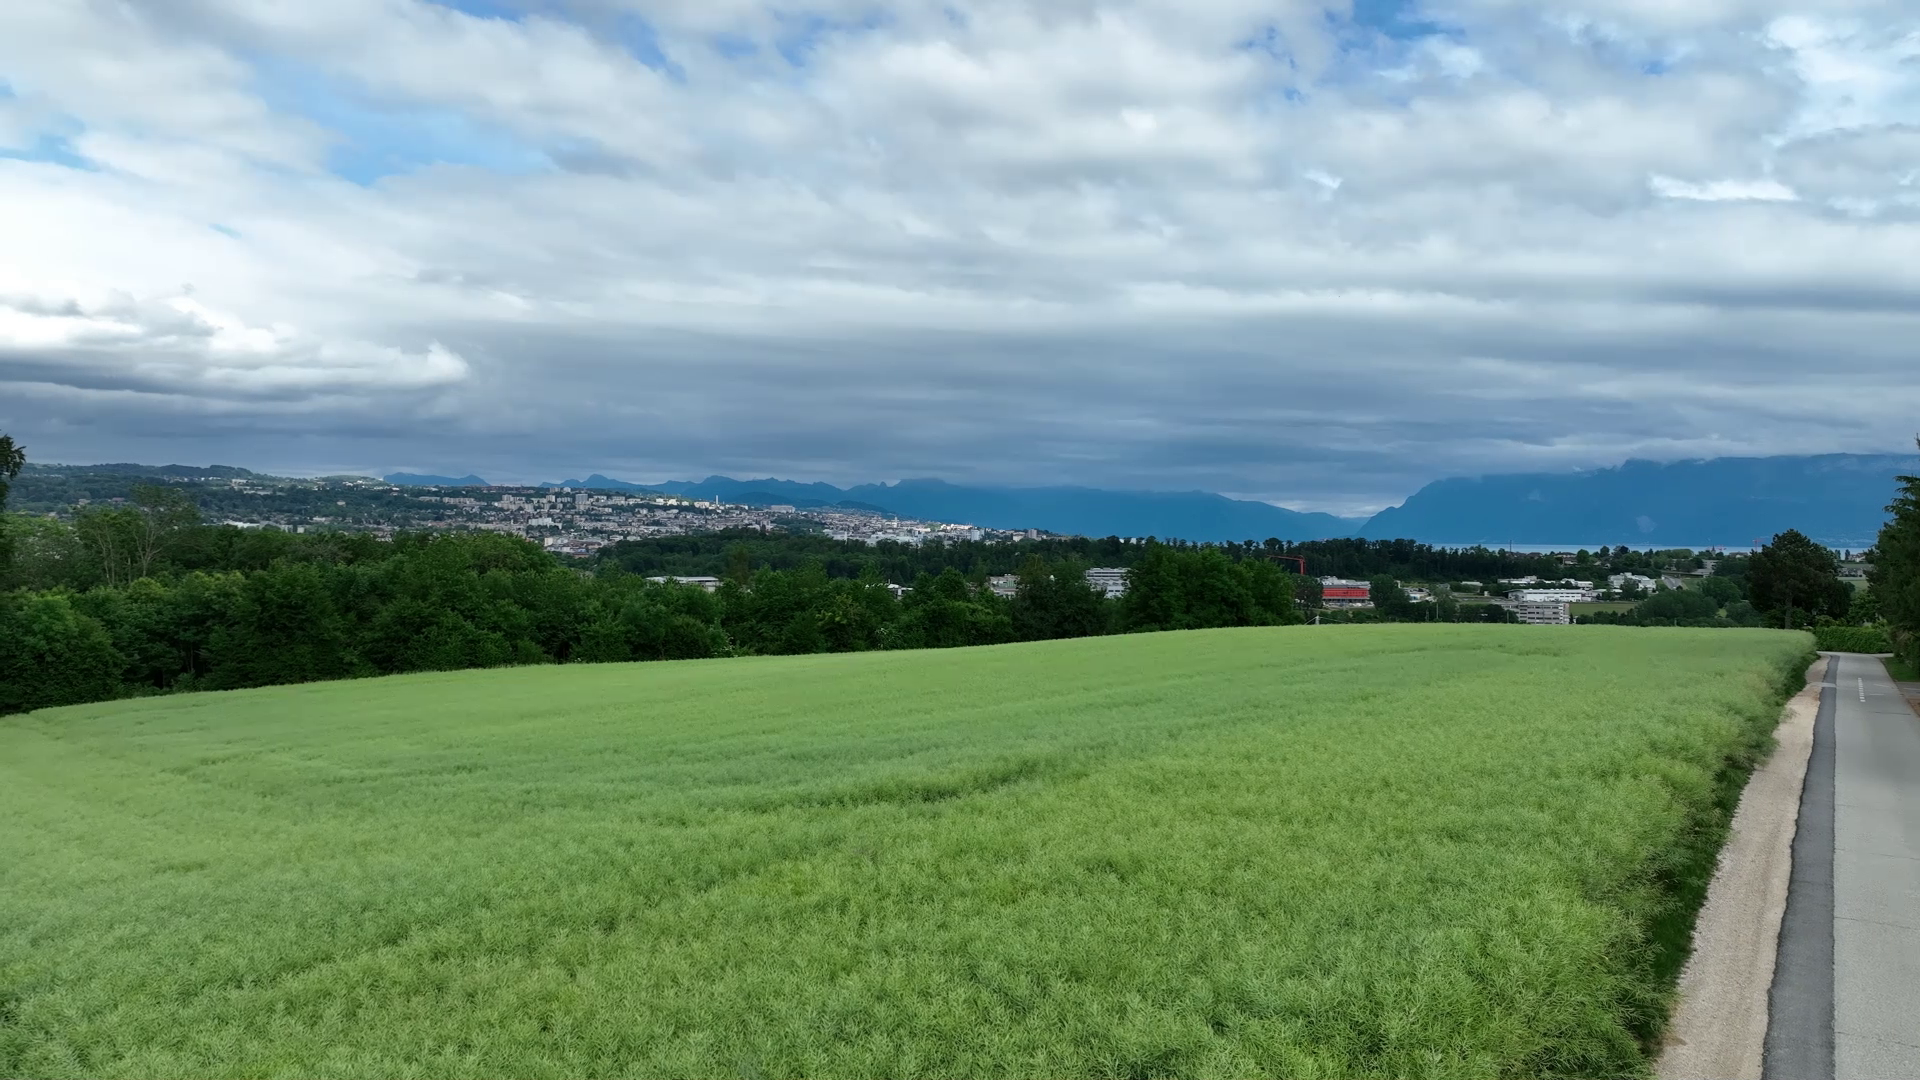

In [17]:
cv2_imshow(frames[10])

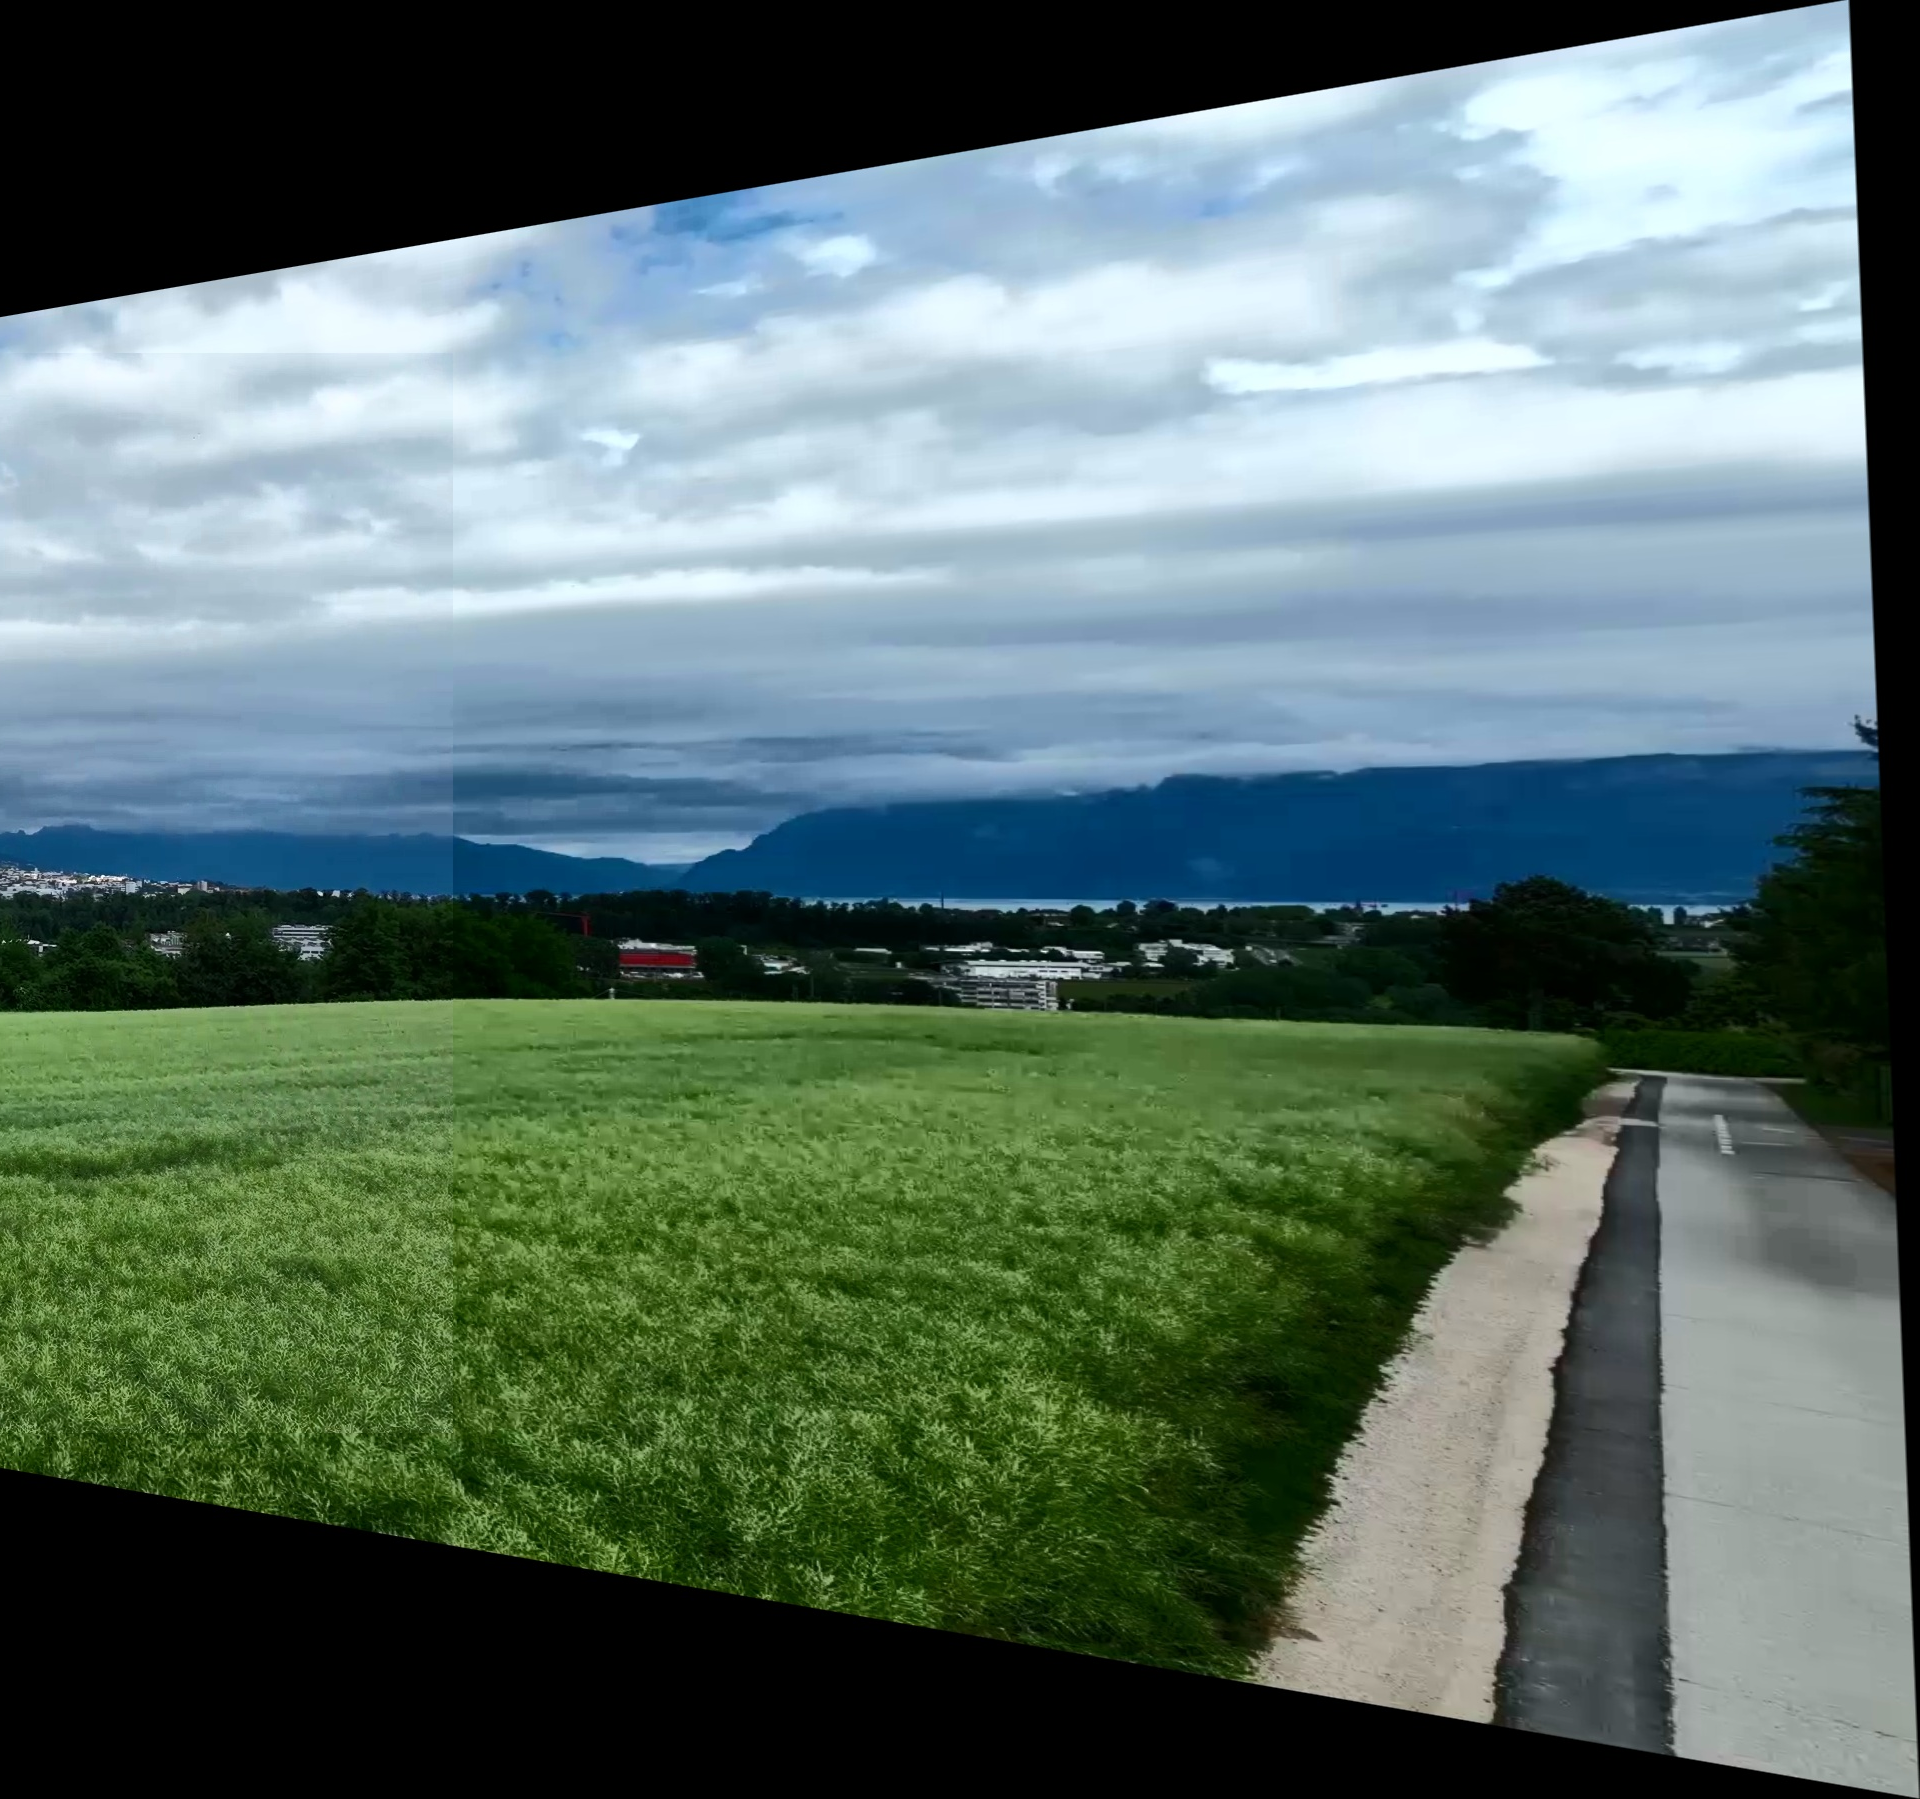

In [37]:
cv2_imshow(cv2.imread('result_sift.jpg')[:, -w:])

# Superglue Matching

In [ ]:
help(frame2tensor)

# Find RMSE of 2 homography matrices

In [ ]:
RMSE_list = []
RMSE_re_list = []
for i, frame in enumerate (frames[:-1]):
    Superglue_M, img1, img2  = get_superglue_homography(frame,frames[i+1])
    SIFT_M, img1, img2 = get_sift_homography(frame,frames[i+1])
    RMSE = ((Superglue_M - SIFT_M)**2).sum() / 9
    RMSE = RMSE**0.5
    RMSE_rel = (np.abs(Superglue_M - SIFT_M)).sum()/ np.abs(SIFT_M).sum()
    RMSE_re_list.append(RMSE_rel)
    # print(f'{RMSE}\t{RMSE_rel}')
    # if (RMSE > 1):
    #     print('='*10)
    #     print(SIFT_M)
    #     print(Superglue_M)
    RMSE_list.append(RMSE)
    # print(RMSE)
    

In [ ]:
np.around(np.mean(RMSE_list),3), np.around(np.mean(RMSE_re_list),3)

In [ ]:
np.around(np.var(RMSE_list),3), np.around(np.var(RMSE_re_list),3)